# Manual Graph of Thoughts Demo: Count Keywords with Simulated Language Model
This example shows how to use the `pure_graph_of_thoughts` package for manual graph of operations construction using the simulated Language Model.

The example task `count_keywords` (defined in `count_keywords.py`) is used.

In [1]:

from pure_graph_of_thoughts.api.language_model import Example
from auto_graph_of_thoughts.tasks.count_keywords import create_op_count, create_count_keywords_task

count_demo_keywords = {
    'France',
    'Italy',
    'Japan',
    'Brazil',
    'Australia',
    'Switzerland'
}
op_count_demo = create_op_count(
    instruction='Count the occurrence of countries in the given text.',
    examples=[
        Example(
            input={
                'text': 'France and Italy are known for their rich cultural heritage and exquisite cuisine, while Japan offers a blend of ancient tradition and cutting-edge technology. Meanwhile, Italy’s scenic countryside, Brazil’s vibrant festivals and Australia’s stunning landscapes attract travelers from around the world.'
            },
            output={
                'count': {
                    'France': 1,
                    'Italy': 2,
                    'Japan': 1,
                    'Brazil': 1,
                    'Australia': 1,
                    'Switzerland': 1
                }
            }
        )
    ],
    keywords=count_demo_keywords
)
count_demo_task = create_count_keywords_task(count_demo_keywords, op_count_demo)
op_keep_best_from_10 = [op for op in count_demo_task.operations if op.name == 'keep_best_from_10'][0]

## Construct Graph of Operations
The graph of operations is constructed.

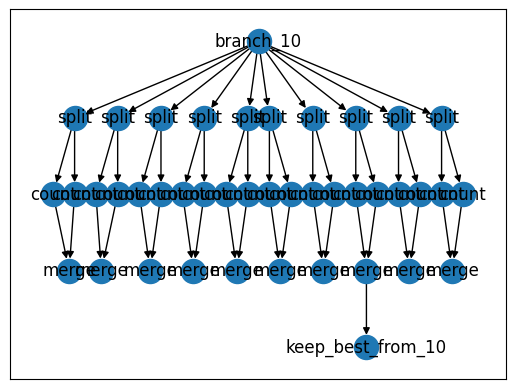

In [2]:
from pure_graph_of_thoughts.api.graph.operation import OperationNode, GraphOfOperations
from pure_graph_of_thoughts.visualization import plot_graph

from auto_graph_of_thoughts.tasks.count_keywords import op_split, op_merge, op_branch_10

def _create_count_keywords_graph_of_operations() -> GraphOfOperations:

    source = OperationNode.of(op_branch_10)

    for _ in range(10):

        split_node = OperationNode.of(op_split)

        source.append(split_node)

        sink_nodes = []
        for _ in range(2):
            count_node = split_node.append_operation(op_count_demo)
            sink_nodes.append(count_node)

        merge_node = OperationNode.of(op_merge)
        for sink_node in sink_nodes:
            sink_node.append(merge_node)

    merge_node.append_operation(op_keep_best_from_10)

    return GraphOfOperations.from_source(source)


count_keywords_graph_of_operations: GraphOfOperations = _create_count_keywords_graph_of_operations()
plot_graph(count_keywords_graph_of_operations)

## Execute Graph of Operations
A simulated language model is used as the executing language model.

In [3]:
from auto_graph_of_thoughts.language_model.simulated_chat_gpt_count_keywords import \
    create_simulated_realistic_chat_gpt_count_keywords
from pure_graph_of_thoughts.controller import CompleteGraphController
import logging

logging.basicConfig(level=logging.INFO)

SEED = 0

ctrl = CompleteGraphController(
    language_model=create_simulated_realistic_chat_gpt_count_keywords(SEED, extra_args={
        'keywords': count_demo_keywords,
        'op_count': op_count_demo
    })
)

INFO:CompleteGraphController:Traversing node 97fb9c75-f8b2-42e0-a5fc-16013312d7d9
INFO:CompleteGraphController:Processing operation ExecOperation(name='branch_10', n_inputs=1, n_outputs=10, type=<OperationType.GENERATE: 'generate'>, output_complexity=Fraction(1, 1))
INFO:CompleteGraphController:Traversing node e74e6a48-a6f4-49e2-8228-ea3b4a859a23
INFO:CompleteGraphController:Processing operation PromptOperation(name='split', n_inputs=1, n_outputs=2, type=<OperationType.GENERATE: 'generate'>, output_complexity=Fraction(1, 2))
INFO:CompleteGraphController:Traversing node 7b6268dd-da7b-4d7c-acc9-2c64550b656d
INFO:CompleteGraphController:Processing operation PromptOperation(name='split', n_inputs=1, n_outputs=2, type=<OperationType.GENERATE: 'generate'>, output_complexity=Fraction(1, 2))
INFO:CompleteGraphController:Traversing node 1b3d013a-cd3b-44f4-b9ed-25d10455da8a
INFO:CompleteGraphController:Processing operation PromptOperation(name='split', n_inputs=1, n_outputs=2, type=<OperationTyp

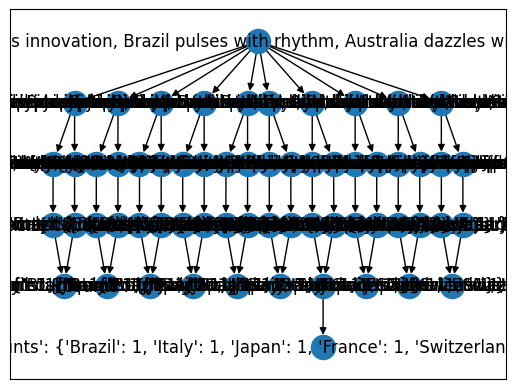

In [4]:
text = 'France and Italy share rich history, Japan inspires innovation, Brazil pulses with rhythm, Australia dazzles with nature, and Switzerland offers peace and precision.'
count_keywords_graph_of_thoughts = ctrl.execute_graph(count_keywords_graph_of_operations, init_state={
    'text': text
})
plot_graph(count_keywords_graph_of_thoughts)

In [5]:
from auto_graph_of_thoughts.tasks.count_keywords import _count_keywords

_count_keywords(count_demo_keywords, text)

Counter({'Switzerland': 1,
         'Brazil': 1,
         'Italy': 1,
         'Japan': 1,
         'Australia': 1,
         'France': 1})